### Import of Functions

In [18]:
import os
import sys
print (os.getcwd())
sys.path.append('/home/Hanna.Drimalla/ml-autism/scripts')

/home/Hanna.Drimalla/ml-autism/ASD-study


In [19]:
#import myreg
import myml
import mycharite

import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np

# Main Code

In [20]:
df, df_audio, action_r, action_c, gaze, audio = mycharite.load('charite')
print ('data loaded')

data loaded


In [21]:
df=mycharite.aq_charite(df)
df=mycharite.exclude_outlier(df) 
df=mycharite.adapt_times(df)
df=mycharite.ados_charite(df)

set()
all participants excluded that were tracked with a successrate less than 0.9
935964
934828
all non-successfully tracked frames excluded
all frames excluded that were tracked with a lower confidence than 0.75
934828
Proband 53 ist korrekt als NT gelabelt


In [22]:
print ('NT ' + str(sum(df.groupby('vpn').mean().asc==0))) #43
print ('ASC ' + str(sum(df.groupby('vpn').mean().asc==1))) #37

NT 43
ASC 37


In [23]:
df[['vpn', 'asc', 'sex']].groupby('vpn').mean().groupby('asc').describe()

sex                                             
      count      mean       std  min  25%  50%  75%  max
asc                                                     
False  43.0  1.488372  0.505781  1.0  1.0  1.0  2.0  2.0
True   37.0  1.513514  0.506712  1.0  1.0  2.0  2.0  2.0

In [6]:
# gucken, ob man das nicht auch noch in mycharite auslagern kann

def calc_speed(df, var):

    epochs = pd.DataFrame()

    speeds = []
    # accelerations
    accs = []
    
    
    #values = epoch.loc[:, ['gaze_0_x', 'gaze_0_y', 'gaze_0_z']]
    #gaze_angle_x

    for i, ((vpn, conversation), epoch) in enumerate(df.groupby(['vpn', 'conversation'])):

  #  for i, ((vpn), epoch) in enumerate(df.groupby(['conversation', 'vpn'])):
        for v in var:
            values = epoch.loc[:, var]

            speed = np.diff(values.values, axis=0) #erste Ableitung
            acc = np.diff(speed, axis=0) #zweite Ableitung
            speed = np.linalg.norm(speed, axis=1) #absolute Werte
            acc = np.linalg.norm(acc, axis=1)

            speeds.append(speed)
            accs.append(acc)

            epochs.loc[i, ('mean_speed_'+v)] = np.nanmean(speed)
            epochs.loc[i, ('mean_acc_'+v)] = np.nanmean(acc)
            epochs.loc[i, ('var_speed_'+v)] = np.nanvar(speed)
            epochs.loc[i, ('var_acc_'+v)] = np.nanvar(acc)

        epochs.loc[i, 'vpn'] = vpn
        epochs.loc[i, 'conversation'] = conversation
        #epochs.loc[i, 'asc'] = np.float(np.mean(epoch.loc[:, ['asc']]))
        #epochs.loc[i, 'frame'] = frame
        

    speeds = pd.DataFrame(speeds)
    accs = pd.DataFrame(accs)

    speeds = pd.concat([speeds, epochs], axis=1)
    accs = pd.concat([accs, epochs], axis=1)

    
    return epochs

def calc_gaze_var(df):
    
    center = lambda x: (x - x.median()) 
    df['gaze_angle_y_centered']=df.groupby(['vpn'])['gaze_angle_y'].transform(center)
    center = lambda x: (x - x.median()) 
    df['gaze_angle_x_centered']=df.groupby(['vpn'])['gaze_angle_x'].transform(center)

    df['gaze_angle_x_centered_abs']=np.abs(df['gaze_angle_x_centered'])
    df['gaze_angle_y_centered_abs']=np.abs(df['gaze_angle_y_centered'])

    df['proband']=(df.conversation=='joy_proband')|(df.conversation=='ekel_proband')|(df.conversation=='neutral_proband')
    df['actress']=(df.conversation=='joy_speaker')|(df.conversation=='ekel_speaker')|(df.conversation=='neutral_speaker')
    df.loc[(df.conversation!='intro'), "whospeaks"] = df[['proband', 'actress']].idxmax(axis=1) 
    
    return df


var=['gaze_angle_x', 'gaze_angle_y']
df_speed_acc=calc_speed(df, var)
df=calc_gaze_var(df)
#df=df.groupby(['vpn', 'conversation']).mean()
df=pd.merge(df, df_speed_acc, on=['vpn', 'conversation'])

### Prediciton of Autism Diagnosis (Charite-Data)

In [7]:
## Prediction based on Features

### Gaze

gaze_angle_x
gaze_angle_x_mean_neutral_participant_has_been_calculated
gaze_angle_x_max_neutral_participant_has_been_calculated
gaze_angle_x_std_neutral_participant_has_been_calculated
gaze_angle_x_argmax_neutral_participant_has_been_calculated
gaze_angle_x_skew_neutral_participant_has_been_calculated
gaze_angle_x_kurtosis_neutral_participant_has_been_calculated
gaze_angle_y
gaze_angle_y_mean_neutral_participant_has_been_calculated
gaze_angle_y_max_neutral_participant_has_been_calculated
gaze_angle_y_std_neutral_participant_has_been_calculated
gaze_angle_y_argmax_neutral_participant_has_been_calculated
gaze_angle_y_skew_neutral_participant_has_been_calculated
gaze_angle_y_kurtosis_neutral_participant_has_been_calculated
gaze_angle_x
gaze_angle_x_mean_neutral_speaker_has_been_calculated
gaze_angle_x_max_neutral_speaker_has_been_calculated
gaze_angle_x_std_neutral_speaker_has_been_calculated
gaze_angle_x_argmax_neutral_speaker_has_been_calculated
gaze_angle_x_skew_neutral_speaker_has_bee

[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

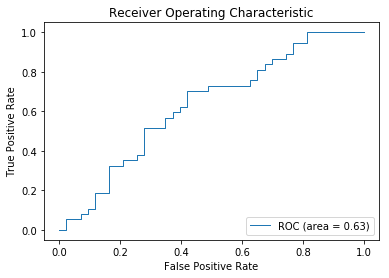

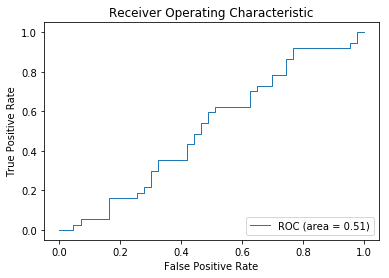

Crossvalidierte Ergebnisse fuer Random Forest
             precision    recall  f1-score   support

        0.0       0.63      0.72      0.67        43
        1.0       0.61      0.51      0.56        37

avg / total       0.62      0.62      0.62        80

Crossvalidierte Ergebnisse fuer Support Vector Machine
             precision    recall  f1-score   support

        0.0       0.54      0.65      0.59        43
        1.0       0.46      0.35      0.40        37

avg / total       0.50      0.51      0.50        80



In [8]:
features=['gaze_angle_x', 'gaze_angle_y']
df, new_features=myml.calc_features(df, features)
new_features.append('sex')
X, y, vpn = myml.prepare_for_classify(df, new_features)
pr_rf_gaze, pr_svm_gaze, y_gaze, test_index_gaze=myml.classification(X, y, 'gaze')

## Face

AU06_r
AU06_r_mean_neutral_participant_has_been_calculated
AU06_r_max_neutral_participant_has_been_calculated
AU06_r_std_neutral_participant_has_been_calculated
AU06_r_argmax_neutral_participant_has_been_calculated
AU06_r_skew_neutral_participant_has_been_calculated
AU06_r_kurtosis_neutral_participant_has_been_calculated
AU12_r
AU12_r_mean_neutral_participant_has_been_calculated
AU12_r_max_neutral_participant_has_been_calculated
AU12_r_std_neutral_participant_has_been_calculated
AU12_r_argmax_neutral_participant_has_been_calculated
AU12_r_skew_neutral_participant_has_been_calculated
AU12_r_kurtosis_neutral_participant_has_been_calculated
AU04_r
AU04_r_mean_neutral_participant_has_been_calculated
AU04_r_max_neutral_participant_has_been_calculated
AU04_r_std_neutral_participant_has_been_calculated
AU04_r_argmax_neutral_participant_has_been_calculated
AU04_r_skew_neutral_participant_has_been_calculated
AU04_r_kurtosis_neutral_participant_has_been_calculated
AU09_r
AU09_r_mean_neutral_part

AU04_r_skew_intro_has_been_calculated
AU04_r_kurtosis_intro_has_been_calculated
AU09_r
AU09_r_mean_intro_has_been_calculated
AU09_r_max_intro_has_been_calculated
AU09_r_std_intro_has_been_calculated
AU09_r_argmax_intro_has_been_calculated
AU09_r_skew_intro_has_been_calculated
AU09_r_kurtosis_intro_has_been_calculated
AU15_r
AU15_r_mean_intro_has_been_calculated
AU15_r_max_intro_has_been_calculated
AU15_r_std_intro_has_been_calculated
AU15_r_argmax_intro_has_been_calculated
AU15_r_skew_intro_has_been_calculated
AU15_r_kurtosis_intro_has_been_calculated
AU06_r
AU06_r_mean_disgust_speaker_has_been_calculated
AU06_r_max_disgust_speaker_has_been_calculated
AU06_r_std_disgust_speaker_has_been_calculated
AU06_r_argmax_disgust_speaker_has_been_calculated
AU06_r_skew_disgust_speaker_has_been_calculated
AU06_r_kurtosis_disgust_speaker_has_been_calculated
AU12_r
AU12_r_mean_disgust_speaker_has_been_calculated
AU12_r_max_disgust_speaker_has_been_calculated
AU12_r_std_disgust_speaker_has_been_calcu

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

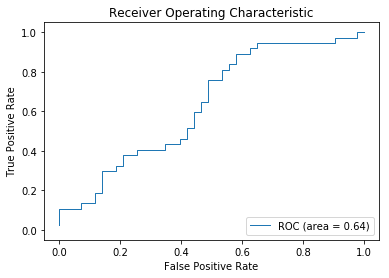

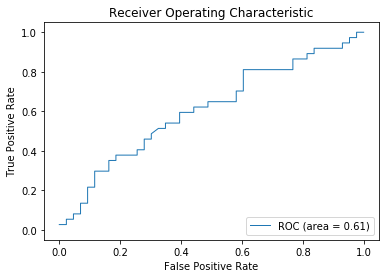

Crossvalidierte Ergebnisse fuer Random Forest
             precision    recall  f1-score   support

        0.0       0.62      0.56      0.59        43
        1.0       0.54      0.59      0.56        37

avg / total       0.58      0.57      0.58        80

Crossvalidierte Ergebnisse fuer Support Vector Machine
             precision    recall  f1-score   support

        0.0       0.64      0.65      0.64        43
        1.0       0.58      0.57      0.58        37

avg / total       0.61      0.61      0.61        80



In [9]:
features=['AU06_r', 'AU12_r', 'AU04_r', 'AU09_r', 'AU15_r']
df, new_features=myml.calc_features(df, features)
new_features.append('sex')
X, y, vpn = myml.prepare_for_classify(df, new_features)
pr_rf_face, pr_svm_face, y_face, test_index_face=myml.classification(X, y, 'face')

AU01_r
AU01_r_mean_neutral_participant_has_been_calculated
AU01_r_max_neutral_participant_has_been_calculated
AU01_r_std_neutral_participant_has_been_calculated
AU01_r_argmax_neutral_participant_has_been_calculated
AU01_r_skew_neutral_participant_has_been_calculated
AU01_r_kurtosis_neutral_participant_has_been_calculated
AU02_r
AU02_r_mean_neutral_participant_has_been_calculated
AU02_r_max_neutral_participant_has_been_calculated
AU02_r_std_neutral_participant_has_been_calculated
AU02_r_argmax_neutral_participant_has_been_calculated
AU02_r_skew_neutral_participant_has_been_calculated
AU02_r_kurtosis_neutral_participant_has_been_calculated
AU04_r
AU04_r_mean_neutral_participant_has_been_calculated
AU04_r_max_neutral_participant_has_been_calculated
AU04_r_std_neutral_participant_has_been_calculated
AU04_r_argmax_neutral_participant_has_been_calculated
AU04_r_skew_neutral_participant_has_been_calculated
AU04_r_kurtosis_neutral_participant_has_been_calculated
AU05_r
AU05_r_mean_neutral_part

AU14_r_max_neutral_speaker_has_been_calculated
AU14_r_std_neutral_speaker_has_been_calculated
AU14_r_argmax_neutral_speaker_has_been_calculated
AU14_r_skew_neutral_speaker_has_been_calculated
AU14_r_kurtosis_neutral_speaker_has_been_calculated
AU15_r
AU15_r_mean_neutral_speaker_has_been_calculated
AU15_r_max_neutral_speaker_has_been_calculated
AU15_r_std_neutral_speaker_has_been_calculated
AU15_r_argmax_neutral_speaker_has_been_calculated
AU15_r_skew_neutral_speaker_has_been_calculated
AU15_r_kurtosis_neutral_speaker_has_been_calculated
AU17_r
AU17_r_mean_neutral_speaker_has_been_calculated
AU17_r_max_neutral_speaker_has_been_calculated
AU17_r_std_neutral_speaker_has_been_calculated
AU17_r_argmax_neutral_speaker_has_been_calculated
AU17_r_skew_neutral_speaker_has_been_calculated
AU17_r_kurtosis_neutral_speaker_has_been_calculated
AU20_r
AU20_r_mean_neutral_speaker_has_been_calculated
AU20_r_max_neutral_speaker_has_been_calculated
AU20_r_std_neutral_speaker_has_been_calculated
AU20_r_ar

AU04_r_kurtosis_joy_speaker_has_been_calculated
AU05_r
AU05_r_mean_joy_speaker_has_been_calculated
AU05_r_max_joy_speaker_has_been_calculated
AU05_r_std_joy_speaker_has_been_calculated
AU05_r_argmax_joy_speaker_has_been_calculated
AU05_r_skew_joy_speaker_has_been_calculated
AU05_r_kurtosis_joy_speaker_has_been_calculated
AU06_r
AU06_r_mean_joy_speaker_has_been_calculated
AU06_r_max_joy_speaker_has_been_calculated
AU06_r_std_joy_speaker_has_been_calculated
AU06_r_argmax_joy_speaker_has_been_calculated
AU06_r_skew_joy_speaker_has_been_calculated
AU06_r_kurtosis_joy_speaker_has_been_calculated
AU07_r
AU07_r_mean_joy_speaker_has_been_calculated
AU07_r_max_joy_speaker_has_been_calculated
AU07_r_std_joy_speaker_has_been_calculated
AU07_r_argmax_joy_speaker_has_been_calculated
AU07_r_skew_joy_speaker_has_been_calculated
AU07_r_kurtosis_joy_speaker_has_been_calculated
AU09_r
AU09_r_mean_joy_speaker_has_been_calculated
AU09_r_max_joy_speaker_has_been_calculated
AU09_r_std_joy_speaker_has_been_c

AU23_r_std_disgust_participant_has_been_calculated
AU23_r_argmax_disgust_participant_has_been_calculated
AU23_r_skew_disgust_participant_has_been_calculated
AU23_r_kurtosis_disgust_participant_has_been_calculated
AU25_r
AU25_r_mean_disgust_participant_has_been_calculated
AU25_r_max_disgust_participant_has_been_calculated
AU25_r_std_disgust_participant_has_been_calculated
AU25_r_argmax_disgust_participant_has_been_calculated
AU25_r_skew_disgust_participant_has_been_calculated
AU25_r_kurtosis_disgust_participant_has_been_calculated
AU26_r
AU26_r_mean_disgust_participant_has_been_calculated
AU26_r_max_disgust_participant_has_been_calculated
AU26_r_std_disgust_participant_has_been_calculated
AU26_r_argmax_disgust_participant_has_been_calculated
AU26_r_skew_disgust_participant_has_been_calculated
AU26_r_kurtosis_disgust_participant_has_been_calculated
AU45_r
AU45_r_mean_disgust_participant_has_been_calculated
AU45_r_max_disgust_participant_has_been_calculated
AU45_r_std_disgust_participant_

AU15_r_mean_disgust_speaker_has_been_calculated
AU15_r_max_disgust_speaker_has_been_calculated
AU15_r_std_disgust_speaker_has_been_calculated
AU15_r_argmax_disgust_speaker_has_been_calculated
AU15_r_skew_disgust_speaker_has_been_calculated
AU15_r_kurtosis_disgust_speaker_has_been_calculated
AU17_r
AU17_r_mean_disgust_speaker_has_been_calculated
AU17_r_max_disgust_speaker_has_been_calculated
AU17_r_std_disgust_speaker_has_been_calculated
AU17_r_argmax_disgust_speaker_has_been_calculated
AU17_r_skew_disgust_speaker_has_been_calculated
AU17_r_kurtosis_disgust_speaker_has_been_calculated
AU20_r
AU20_r_mean_disgust_speaker_has_been_calculated
AU20_r_max_disgust_speaker_has_been_calculated
AU20_r_std_disgust_speaker_has_been_calculated
AU20_r_argmax_disgust_speaker_has_been_calculated
AU20_r_skew_disgust_speaker_has_been_calculated
AU20_r_kurtosis_disgust_speaker_has_been_calculated
AU23_r
AU23_r_mean_disgust_speaker_has_been_calculated
AU23_r_max_disgust_speaker_has_been_calculated
AU23_r_s

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 1

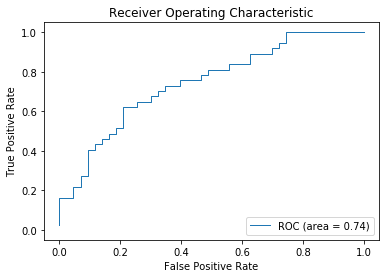

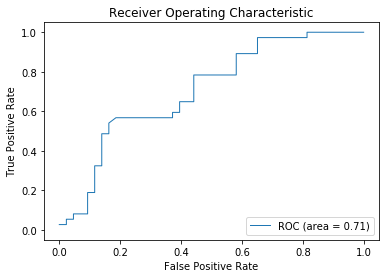

Crossvalidierte Ergebnisse fuer Random Forest
             precision    recall  f1-score   support

        0.0       0.70      0.74      0.72        43
        1.0       0.68      0.62      0.65        37

avg / total       0.69      0.69      0.69        80

Crossvalidierte Ergebnisse fuer Support Vector Machine
             precision    recall  f1-score   support

        0.0       0.65      0.81      0.72        43
        1.0       0.69      0.49      0.57        37

avg / total       0.67      0.66      0.65        80



In [10]:
# hier für das gesamte Gesicht (alle AUs)
df, new_features=myml.calc_features(df, action_r)
new_features.append('sex')
X, y, vpn = myml.prepare_for_classify(df, new_features)
pr_rf_face_full, pr_svm_face_full, y_face_full, test_index_face_full=myml.classification(X, y, 'face_full')

### Audio

[[ -5.51602994e+02   7.58202302e+01   5.29542920e+00 ...,  -3.43202329e+00
   -2.61145540e-01   1.00000000e+00]
 [ -5.02643989e+02   6.79576324e+01   9.66786705e+00 ...,   3.83449434e+00
    7.59981248e-01   2.00000000e+00]
 [ -5.42541103e+02   8.24246568e+01   7.64389674e+00 ...,  -1.32258922e+00
   -2.23546806e-01   2.00000000e+00]
 ..., 
 [ -5.25124597e+02   7.34608203e+01   1.18266343e+01 ...,   2.47793127e+00
   -2.05602737e+00   2.00000000e+00]
 [ -5.52501031e+02   7.59873789e+01   4.99942304e+00 ...,   7.38255827e+00
   -1.03448455e+00   1.00000000e+00]
 [ -5.44704514e+02   7.95181597e+01   4.34565648e+00 ...,  -5.37276662e-01
   -3.96419404e-01   1.00000000e+00]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 2

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 68 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 69 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 75
 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 1

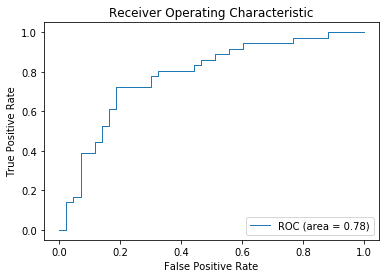

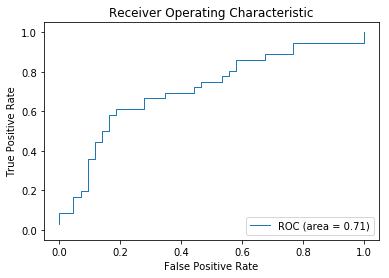

Crossvalidierte Ergebnisse fuer Random Forest
             precision    recall  f1-score   support

        0.0       0.78      0.81      0.80        43
        1.0       0.76      0.72      0.74        36

avg / total       0.77      0.77      0.77        79

Crossvalidierte Ergebnisse fuer Support Vector Machine
             precision    recall  f1-score   support

        0.0       0.71      0.84      0.77        43
        1.0       0.75      0.58      0.66        36

avg / total       0.73      0.72      0.72        79



In [16]:
audio=['spectrum_0', 'spectrum_1', 'spectrum_2', 'spectrum_3', 'spectrum_4', 'spectrum_5',
       'spectrum_6', 'spectrum_7', 'spectrum_8', 'spectrum_9', 'spectrum_10',
       'spectrum_11', 'spectrum_12', 'spectrum_13', 'spectrum_14',
       'spectrum_15', 'spectrum_16', 'spectrum_17', 'spectrum_18',
       'spectrum_19', 'spectrum_20', 'spectrum_21', 'spectrum_22',
       'spectrum_23', 'spectrum_24', 'spectrum_25', 'spectrum_26',
       'spectrum_27', 'spectrum_28', 'spectrum_29', 'spectrum_30',
       'spectrum_31', 'spectrum_32', 'spectrum_33', 'spectrum_34',
       'spectrum_35', 'spectrum_36', 'spectrum_37', 'spectrum_38',
       'spectrum_39', 'pitch', 'meanF0Hz',
       'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter',
       'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer',
       'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'JitterPCA',
       'ShimmerPCA']


df_audio['asc']=(df_audio.asd==11)

audio.append('sex_x')

X, y, vpn = myml.prepare_for_classify(df_audio, audio)
pr_rf_audio, pr_svm_audio, y_audio, test_index_audio=myml.classification(X, y, 'all')


### Total

In [ ]:
features=['AU06_r', 'AU12_r', 'AU04_r', 'AU09_r', 'AU15_r',
          'AU06_c', 'AU12_c', 'AU04_c', 'AU09_c', 'AU15_c', 
          'gaze_angle_x', 'gaze_angle_y']

df, new_features=myml.calc_features(df, features)
df_total=pd.merge(df, df_audio, on='vpn').reset_index()

new_features.append('sex')
new_features=new_features+audio

X, y, vpn = myml.prepare_for_classify(df_total, new_features)
pr_rf_all, pr_svm_all, y_all, test_index_all=myml.classification(X, y, 'all')

AU06_r
AU06_r_mean_neutral_participant_has_been_calculated
AU06_r_max_neutral_participant_has_been_calculated
AU06_r_std_neutral_participant_has_been_calculated
AU06_r_argmax_neutral_participant_has_been_calculated
AU06_r_skew_neutral_participant_has_been_calculated
AU06_r_kurtosis_neutral_participant_has_been_calculated
AU12_r
AU12_r_mean_neutral_participant_has_been_calculated
AU12_r_max_neutral_participant_has_been_calculated
AU12_r_std_neutral_participant_has_been_calculated
AU12_r_argmax_neutral_participant_has_been_calculated
AU12_r_skew_neutral_participant_has_been_calculated
AU12_r_kurtosis_neutral_participant_has_been_calculated
AU04_r
AU04_r_mean_neutral_participant_has_been_calculated
AU04_r_max_neutral_participant_has_been_calculated
AU04_r_std_neutral_participant_has_been_calculated
AU04_r_argmax_neutral_participant_has_been_calculated
AU04_r_skew_neutral_participant_has_been_calculated
AU04_r_kurtosis_neutral_participant_has_been_calculated
AU09_r
AU09_r_mean_neutral_part

AU04_r_mean_joy_participant_has_been_calculated
AU04_r_max_joy_participant_has_been_calculated
AU04_r_std_joy_participant_has_been_calculated
AU04_r_argmax_joy_participant_has_been_calculated
AU04_r_skew_joy_participant_has_been_calculated
AU04_r_kurtosis_joy_participant_has_been_calculated
AU09_r
AU09_r_mean_joy_participant_has_been_calculated
AU09_r_max_joy_participant_has_been_calculated
AU09_r_std_joy_participant_has_been_calculated
AU09_r_argmax_joy_participant_has_been_calculated
AU09_r_skew_joy_participant_has_been_calculated
AU09_r_kurtosis_joy_participant_has_been_calculated
AU15_r
AU15_r_mean_joy_participant_has_been_calculated
AU15_r_max_joy_participant_has_been_calculated
AU15_r_std_joy_participant_has_been_calculated
AU15_r_argmax_joy_participant_has_been_calculated
AU15_r_skew_joy_participant_has_been_calculated
AU15_r_kurtosis_joy_participant_has_been_calculated
AU06_c
AU06_c_mean_joy_participant_has_been_calculated
AU06_c_max_joy_participant_has_been_calculated
AU06_c_s

AU06_c_argmax_disgust_participant_has_been_calculated
AU06_c_skew_disgust_participant_has_been_calculated
AU06_c_kurtosis_disgust_participant_has_been_calculated
AU12_c
AU12_c_mean_disgust_participant_has_been_calculated
AU12_c_max_disgust_participant_has_been_calculated
AU12_c_std_disgust_participant_has_been_calculated
AU12_c_argmax_disgust_participant_has_been_calculated
AU12_c_skew_disgust_participant_has_been_calculated
AU12_c_kurtosis_disgust_participant_has_been_calculated
AU04_c
AU04_c_mean_disgust_participant_has_been_calculated
AU04_c_max_disgust_participant_has_been_calculated
AU04_c_std_disgust_participant_has_been_calculated
AU04_c_argmax_disgust_participant_has_been_calculated
AU04_c_skew_disgust_participant_has_been_calculated
AU04_c_kurtosis_disgust_participant_has_been_calculated
AU09_c
AU09_c_mean_disgust_participant_has_been_calculated
AU09_c_max_disgust_participant_has_been_calculated
AU09_c_std_disgust_participant_has_been_calculated
AU09_c_argmax_disgust_participa

## Prediction based on AQ

In [ ]:
asq=df.groupby('vpn').mean().dropna(subset=['asq'])
X, y, vpn = myml.prepare_for_classify(asq, ['asq', 'sex'])
pr_rf_aq, pr_svm_aq, y_true_aq, test_index_aq=myml.classification(X, y, 'asq')
#lr_pr, y_true_lr, test_index=myml.threshold(X_asq[:, np.newaxis], y_asq)

## Prediction based on Clinical View 

In [ ]:
experts=mycharite.load_experts(df)
X, y, vpn = myml.prepare_for_classify(experts, ['Value', 'sex'])
pr_rf_clinical, pr_svm_clinical, y_true_clinical, test_index_clinical=myml.classification(X, y, 'Clinical')

## Combination of Features and AQ

In [ ]:
features=['AU06_r', 'AU12_r', 'AU04_r', 'AU09_r', 'AU15_r',
          'AU06_c', 'AU12_c', 'AU04_c', 'AU09_c', 'AU15_c', 
          'gaze_angle_x', 'gaze_angle_y']

df, new_features=myml.calc_features(df, features)
df_total=pd.merge(df, df_audio, on='vpn').reset_index()

new_features.append('sex')
new_features=new_features+audio

all_and_aq=new_features.append('asq')
X, y, vpn = myml.prepare_for_classify(df_total, all_and_aq)
pr_rf_all_plusAQ, pr_svm_all_plusAQ, y_all_plusAQ, test_index_all_plusAQ=myml.classification(X, y, 'all_plus_aq')

## Combination of Features and Clinical View

In [ ]:
features=['AU06_r', 'AU12_r', 'AU04_r', 'AU09_r', 'AU15_r',
          'AU06_c', 'AU12_c', 'AU04_c', 'AU09_c', 'AU15_c', 
          'gaze_angle_x', 'gaze_angle_y']

df, new_features=myml.calc_features(df, features)
df_total=pd.merge(df, df_audio, on='vpn').reset_index()

new_features.append('sex')
new_features=new_features+audio

all_and_clinic=new_features.append('Value')
df_total_clinical=pd.merge(df_total, experts, on='vpn').reset_index()

X, y, vpn = myml.prepare_for_classify(df_total_clinical, all_and_clinic)
pr_rf_all_plusClinic, pr_svm_all_plusClinic, y_all_plusClinic, test_index_all_plusClinic=myml.classification(X, y, 'all_plus_clinic')

### Graphics

In [ ]:
myml.features_roc_graph(y_true_total, y_occ, y_int, y_gaze, y_true_face, y_true_audio,
                       pr_rf_total[:,1], pr_svm_total[:,1],
                       pr_svm_occ[:,1], pr_rf_occ[:,1],  
                       pr_svm_int[:,1], pr_rf_int[:,1], 
                       pr_svm_gaze[:,1], pr_rf_gaze[:,1],
                       pr_svm_face[:,1], pr_rf_face[:,1],
                       pr_rf_audio[:,1], pr_svm_audio[:,1],
                       '(all)', '(occ)', '(int)', '(gaze)', '(face)', '(audio)', 'Feature_Comparison')

#### Correlation of Prediction based on Features and based on AQ (not correlated -> additional value of features)

In [ ]:
print ('Corrrelation of Prediction and Diagnosis')
print (asq>0)
plt.close()
y_true_new=y_true[asq>0]
tree=pr_rf[asq>0,1]
aq= lr_pr[:,1]
print (scipy.stats.pointbiserialr(pr_rf[:,1], y_true))

print ('Correlation of Prediction based on Features and based on AQ (seperated by NT and ASD)')
tree_asc=tree[y_true_new==True]
aq_asc=aq[y_true_new==True]

print (scipy.stats.normaltest(tree_asc))
print (scipy.stats.spearmanr(tree_asc, aq_asc))

tree_nt=tree[y_true_new==False]
aq_nt=aq[y_true_new==False]
print (scipy.stats.normaltest(tree_nt))
print (scipy.stats.spearmanr(tree_nt, aq_nt))

# Regression (ADOS and ADI-R)

In [ ]:
df_Reg=mycharite.ados_charite(df)

In [ ]:
#df_Reg, action_r_Reg, action_c_Reg, gaze_Reg =prep.load('charite', 'lab')
#df_Reg=prep.aq_charite(df_Reg, 'lab')
#df_Reg=prep.exclude_outlier(df_Reg)
#df_Reg, start_Reg, end_Reg=prep.get_convparts(df_Reg)
#prep.check(df_Reg)

#df=ados_charite(df)

print ('NT ' + str(sum(df_Reg.groupby('vpn').mean().asc==0)))
print ('ASC ' + str(sum(df_Reg.groupby('vpn').mean().asc==1))) 


#df[df.adir_social>0].groupby('vpn').mean().reset_index()


#calculation of features for both datasets
#df_Reg, features_part_Reg=subfeatures(df_Reg, action_r_Reg, action_c_Reg)

In [ ]:
plt.scatter(df_Reg[df_Reg.asc==1].groupby('vpn').adir_social.mean(), df_Reg[df_Reg.asc==1].groupby('vpn').asq.mean())
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(df_Reg[df_Reg.asc==1].groupby('vpn').ados_total.mean(), df_Reg[df_Reg.asc==1].groupby('vpn').asq.mean())
plt.yticks(fontsize=16)    
plt.xticks(fontsize=16)  
plt.xlabel('ADOS', fontsize=18)
plt.ylabel('AQ', fontsize=18)
plt.savefig('ADOSandAQ.png')

### ADOS

In [ ]:
X_ados_rf, rescaledX_ados_rf, y_ados_rf, diagnosis = myreg.prepare_for_regress_RF(df_Reg, df_audio, 'charite', 'ADOS', features_part_Reg)
X_ados_rf_social, rescaledX_ados_rf_social, y_ados_rf_social, diagnosis = myreg.prepare_for_regress_RF(df_Reg, df_audio,'charite', 'ADOS_social', features_part_Reg)
X_ados_rf_communication, rescaledX_ados_rf_communication, y_ados_rf_communication, diagnosis = myreg.prepare_for_regress_RF(df_Reg, df_audio,'charite', 'ADOS_communication', features_part_Reg)

In [ ]:
## Prediction of ADOS - Social
print ('social')
y_pred_svr_ADOS_social, y_pred_tree_ADOS_social, y_true_ADOS_social, y_base_ADOS_social, tree_ADOS_social, svr_ADOS_social=myreg.regression(X_ados_rf_social, y_ados_rf_social, name='ADOS_social')

## Prediction of ADOS - Communication
print ('communication')
y_pred_svr_ADOS_communication, y_pred_tree_ADOS_communication, y_true_ADOS_communication, y_base_ADOS_communication, tree_ADOS_communication, svr_ADOS_communication=myreg.regression(X_ados_rf_communication, y_ados_rf_communication, name='ADOS_communication')

## Prediction of ADOS - Total
print ('total')
y_pred_svr_ADOS, y_pred_tree_ADOS, y_true_ADOS, y_base_ADOS, tree_ADOS, svr_ADOS=myreg.regression(X_ados_rf, y_ados_rf, name='ados')

In [ ]:
myreg.reg_cor(x=y_pred_svr_ADOS, y=y_true_ADOS, x_label='Predicition of SVR', y_label='ADOS Value')
myreg.reg_cor(x=y_pred_tree_ADOS, y=y_true_ADOS, x_label='Predicition of RF', y_label='ADOS Value')

In [ ]:
### ADOS

sns.regplot(df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().asq, df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().ados_total)
plt.show()

sns.regplot(df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().asq, df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().ados_social)
plt.show()

plt.scatter(df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().asq, df_Reg[df_Reg.ados_total>0].groupby('vpn').mean().ados_commu)
plt.show()

### ADI-R

In [ ]:
X_adi_rf_social, rescaledX_adi_rf_social, y_adi_rf_social, diagnosis = myreg.prepare_for_regress_RF(df_Reg, df_audio, 'charite', 'ADI', features_part)

In [ ]:
print ('social')
y_pred_svr_ADI_social, y_pred_tree_ADI_social, y_true_ADI_social, y_base_ADI_social, tree_ADI_social, svr_ADI_social=myreg.regression(X_adi_rf_social, y_adi_rf_social, name='ADI')

## Prediction of ADI Social based on AQ
print ('social (based on AQ)')
y_pred_svr_AQ, y_pred_tree_AQ, y_true_AQ, y_base_AQ, tree_AQ, svr_AQ=myreg.regression(diagnosis[diagnosis>0].reshape(-1, 1), y_adi_rf_social[diagnosis>0], name='ADI')

In [ ]:
myreg.evaluate(y_pred_svr_ADI_social[diagnosis>0], y_pred_tree_ADI_social[diagnosis>0], y_adi_rf_social[diagnosis>0], y_pred_svr_AQ)

In [ ]:
myreg.evaluate(y_pred_svr_ADI_social[diagnosis>0], y_pred_tree_ADI_social[diagnosis>0], y_adi_rf_social[diagnosis>0], y_pred_svr_AQ)
print ('ADI Prediction vs. True Value')
plt.scatter(y_pred_tree_ADI_social[diagnosis>0], y_adi_rf_social[diagnosis>0])
print (stats.spearmanr(y_pred_tree_ADI_social, y_adi_rf_social))
plt.show()

In [ ]:
plt.savefig('ADI_WTAS')